# Structural Uncertainty — KL EXPANSION

This notebook implements a **technical**  workflow for uncertainty quantification of a truss bridge using:
- Finite Element Method (FEM) for structural response
- Monte Carlo (MC) sampling for uncertainty propagation
- Karhunen–Loève (KL) spectral decomposition
-  Neural Network surrogate for fast inference




## Introduction

This notebook implements a structured and academically styled analysis of uncertainty
quantification for a truss structure. Each section includes concise theoretical context
to explain the methodology being applied.

## Finite Element Relation

The structural response is governed by:

\[
K u = f,
\]

where:
- \( K \) is the global stiffness matrix,
- \( u \) is the nodal displacement vector,
- \( f \) is the applied load vector.



In [1]:
# %% Imports (consolidated)
import numpy as np
import math
import time
import pandas as pd
from math import cos, sin, pi
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm, multivariate_normal
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import time


## 1. FEM Setup

Free body diagram of a 2D Warren truss depicting the distribution of forces across the body. In order to perform Finite element analysis the structure is divided into 11 elements and 7 nodes as shown below.



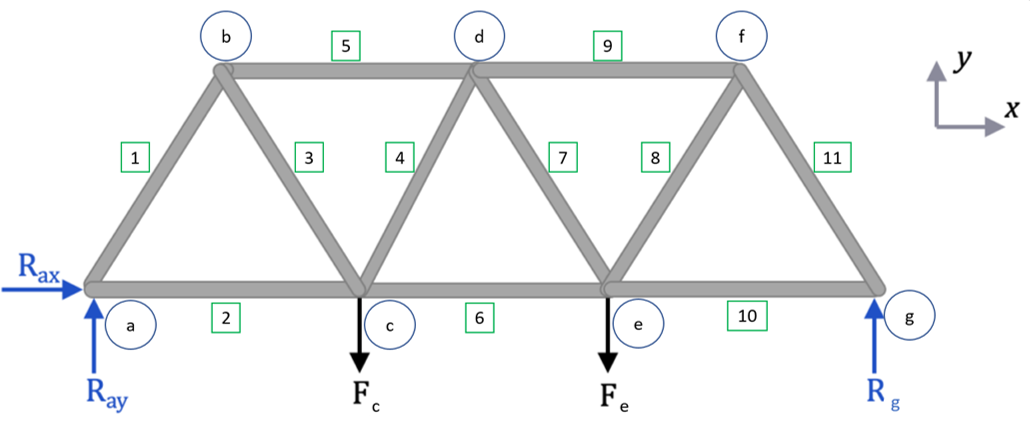

In [5]:
# %% FEM Setup
# Provide functions: assemble global stiffness, apply boundary conditions, solve Ku=f
# If these exist below, leave this cell as an anchor for navigation.# %%
#initialise lists for the finite element method variables
E_list = [200000,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000]                # E for each element (MPa or N/mm2)
A_list = [11300,11300,11300,11300,11300,11300,11300,11300,11300,11300,11300]                           # Cross section area for each element (mm2)
L_list = [4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000]                                      # length of each element (mm)


angle_list = [60, 0, 120, 60, 0, 0, 120, 60, 0, 0, 120]              #rotation angle for each element

global_idx_list = [[0, 1],[0, 2],[2, 1],[2, 3],[1, 3],[2, 4],
                   [4, 3],[4, 5],[3, 5],[4, 6],[6, 5]]               # start and end node for each element

max_glob_id = 14                                                     # number of degrees of freedom
n_elm = 11


#generate element stiffness matrix

def local_stiff_mat(a, E, A, L):                                     # elemental stiffness matrix
    k = np.zeros((4, 4))
    angle = a * pi / 180
    k[0] = [(cos(angle))**2, cos(angle)*sin(angle), -(cos(angle)**2), -cos(angle)*sin(angle)]
    k[1] = [cos(angle)*sin(angle), (sin(angle))**2, -cos(angle)*sin(angle), -(sin(angle)**2)]
    k[2] = [-(cos(angle)**2), -cos(angle)*sin(angle), (cos(angle))**2, cos(angle)*sin(angle)]
    k[3] = [-cos(angle)*sin(angle), -(sin(angle)**2), cos(angle)*sin(angle), (sin(angle))**2]
    return k


#scaling from local coordinate to global coordinate
def loc_to_global_map(id_glob, max_glob_index):     # mapping
    A = np.zeros((max_glob_index, 4))
    id_0 = id_glob[0]
    id_1 = id_glob[1]
    A[id_0 * 2][0] = 1
    A[(id_0 * 2) + 1][1] = 1
    A[id_1 * 2][2] = 1
    A[(id_1 * 2) + 1][3] = 1
    return A


#generate global stofness matric
def glob_stiffness(angle_list, global_idx_list, E_list, A_list, L_list):    # global stiffness matrix
    glob_stiff = np.zeros((max_glob_id, max_glob_id))
    for i in range(n_elm):
        theta = angle_list[i]
        global_idx = global_idx_list[i]
        E_loc = E_list[i]
        A_loc = A_list[i]
        L_loc = L_list[i]
        k_loc = local_stiff_mat(theta, E_loc, A_loc, L_loc)
        matA = loc_to_global_map(global_idx, max_glob_id)
        k_glob = ((E_loc * A_loc) / L_loc) * np.dot(np.dot(matA, k_loc), np.transpose(matA))
        glob_stiff += k_glob
    return glob_stiff


#stifness matrix
matK = glob_stiffness(angle_list, global_idx_list, E_list, A_list, L_list)


#doing normal distribution for the F nodal element 3 and 5

def force_gen():   # generating downward forces at node 3 and 5 (f3y f5y)
    s = 100
    cov = [[s * s, 0], [0, s * s]]
    eps = np.random.multivariate_normal((-2011542.5 , -2011542.5), cov)     # mean of the force = 4011500/2 = 2005750 N
    force = [0, 0, 0, 0, 0, eps[0], 0, 0, 0, eps[1], 0, 0, 0, 0]
    return force


vecF = np.array(force_gen())    # force vector

def force_unif(n_samples):
  #f_max = -4011500
  f_max = -4023085.0
  df = f_max / n_samples;
  force_all = []
  for i in range(n_samples):
    force = [0, 0, 0, 0, 0, (i+1) * df/2., 0, 0, 0, (i+1) * df/2., 0, 0, 0, 0]
    force_all.append(force)

  return np.transpose(force_all)

# solving for u and assigning boundry conditions

bc_index = [0, 1, 13]
def compute_soln(matK, vecF):
    for j in bc_index:
        matK[j, :] = 0
        matK[:, j] = 0
        matK[j, j] = 1
        vecF[j] = 0
    u = np.linalg.solve(matK, vecF)
    return u

solution = compute_soln(matK, vecF)  # performimg finite element method




## 2. Monte Carlo Propagation

In [6]:
# %% Monte Carlo
# Functions and loops for sampling loads and computing response statistics.
#perform simulation
start_time = time.time()
n_sim = 1000
u = np.zeros((max_glob_id, n_sim))  # 14 x n_sim
# f = np.zeros((max_glob_id, n_sim))

f = force_unif(n_sim)

for k in range(n_sim):              # getting displacements from the generated forces
    vecF = np.array(force_gen())
    f[:, k] = force_gen()
    vecF = f[:, k]
    u[:, k] = compute_soln(matK, vecF)


f = np.transpose(f)
u = np.transpose(u)
covU_montecarlo = np.cov(u.T)
montecarlo_time = time.time() - start_time
print(matK.shape)

print("force : {} " .format(f[:5]))
print("displacement : {} " .format(u[:5]))
print(f'shape of the forces matrix {f.shape} || shape of the displacement matrix {u.shape}')


(14, 14)
force : [[       0.                0.                0.                0.
         0.         -2011565.91533747        0.                0.
         0.         -2011565.91369569        0.                0.
         0.                0.        ]
 [       0.                0.                0.                0.
         0.         -2011589.44743859        0.                0.
         0.         -2011488.24399564        0.                0.
         0.                0.        ]
 [       0.                0.                0.                0.
         0.         -2011518.30377284        0.                0.
         0.         -2011733.82802447        0.                0.
         0.                0.        ]
 [       0.                0.                0.                0.
         0.         -2011643.78311203        0.                0.
         0.         -2011511.07526674        0.                0.
         0.                0.        ]
 [       0.                0.      

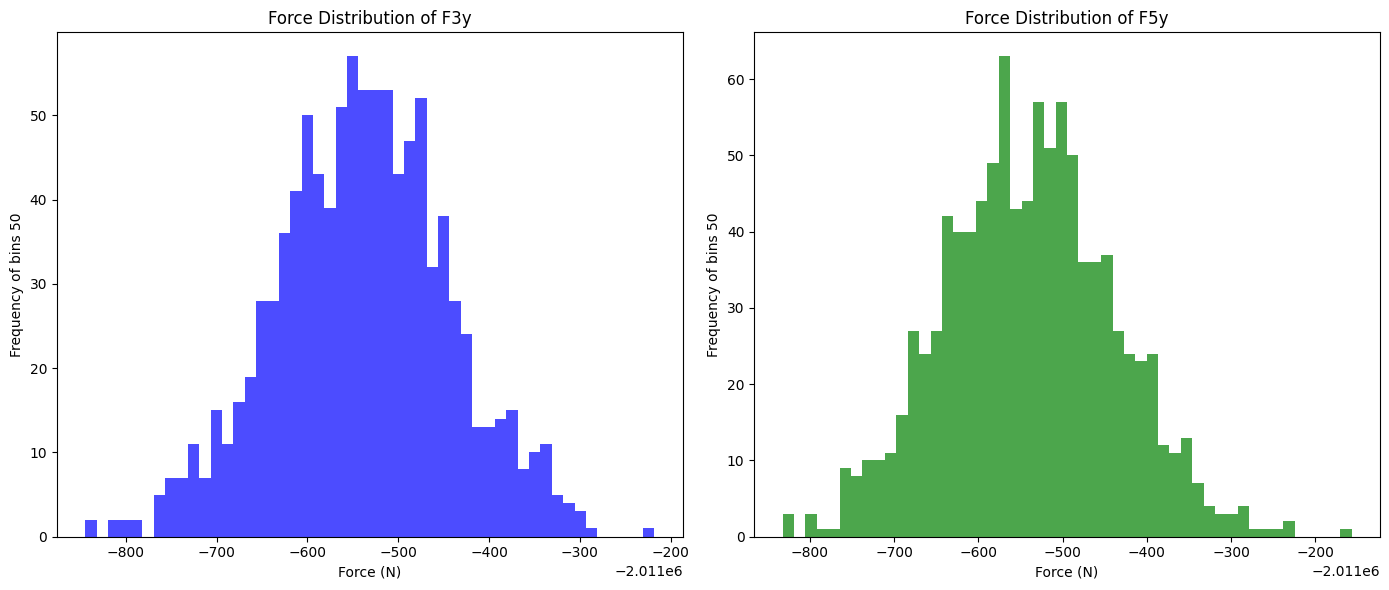

In [7]:
#plotting histograms for visualization
plt.figure(figsize=(14, 6))
try:
  plt.subplot(1, 2, 1)
  plt.hist(f[:,[5]], bins=50, color='blue', alpha=0.7)
  plt.title('Force Distribution of F3y')
  plt.xlabel('Force (N)')
  plt.ylabel('Frequency of bins 50')

  plt.subplot(1, 2, 2)
  plt.hist(f[:,[9]], bins=50, color='green', alpha=0.7)
  plt.title('Force Distribution of F5y')
  plt.xlabel('Force (N)')
  plt.ylabel('Frequency of bins 50')

  plt.tight_layout()
  plt.show()
except:
  print(f.shape)



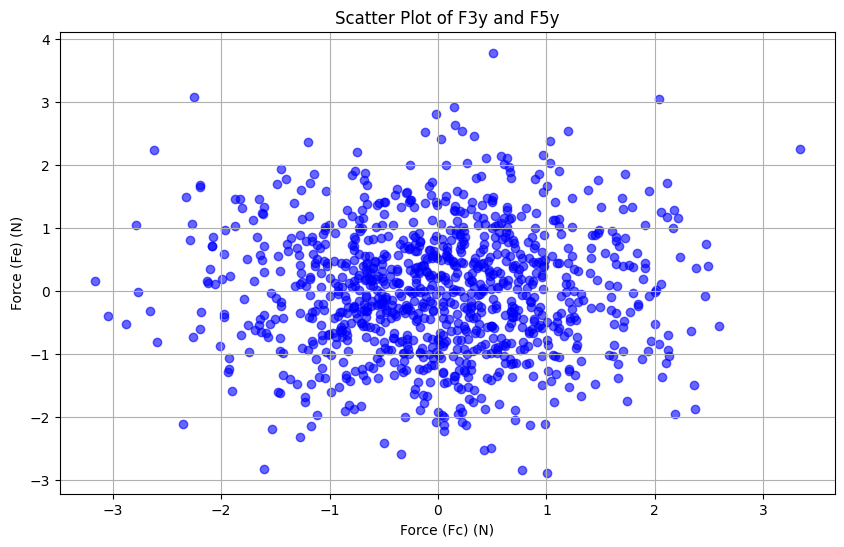

In [21]:
# Scatter plot of forces
plt.figure(figsize=(10, 6))
plt.scatter(f[:,[5]], f[:,[9]], alpha=0.6, color='blue')
plt.title('Scatter Plot of F3y and F5y')
plt.xlabel('Force (Fc) (N)')
plt.ylabel('Force (Fe) (N)')
plt.grid(True)
plt.show()

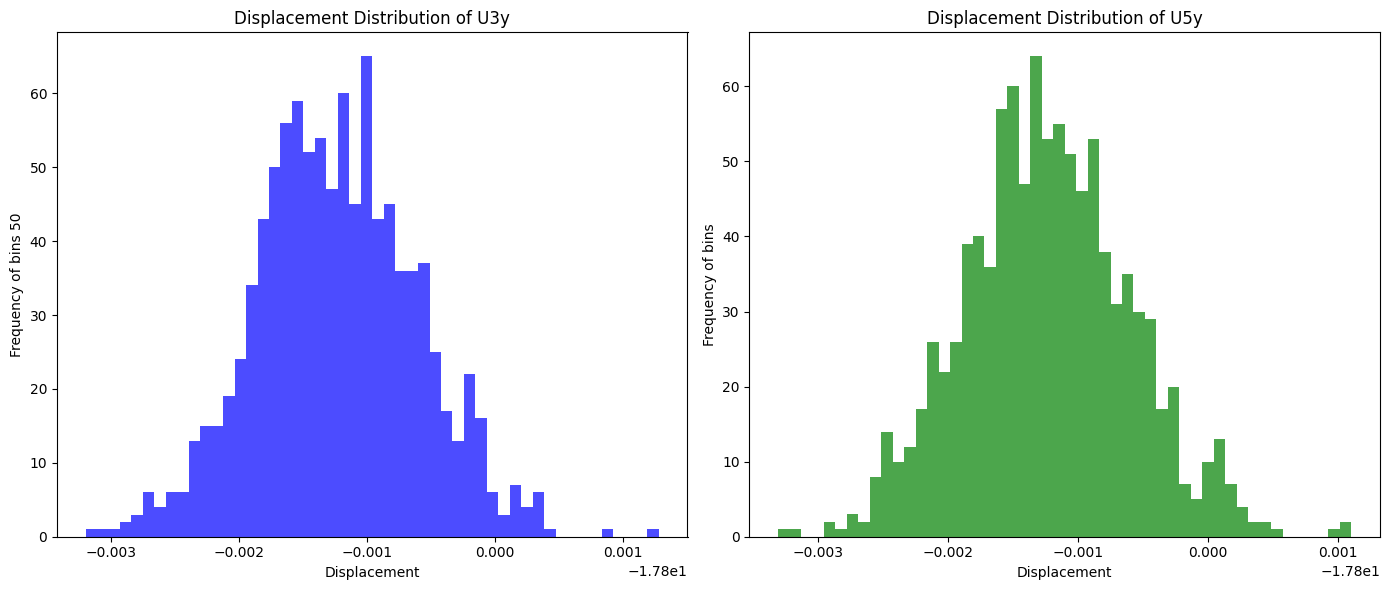

In [8]:
#histogram for the displacements for visualization
plt.figure(figsize=(14, 6))
try:
  plt.subplot(1, 2, 1)
  plt.hist(u[:,[5]], bins=50, color='blue', alpha=0.7)
  plt.title('Displacement Distribution of U3y')
  plt.xlabel('Displacement')
  plt.ylabel('Frequency of bins 50')

  plt.subplot(1, 2, 2)
  plt.hist(u[:,[9]], bins=50, color='green', alpha=0.7)
  plt.title('Displacement Distribution of U5y')
  plt.xlabel('Displacement')
  plt.ylabel('Frequency of bins')

  plt.tight_layout()
  plt.show()
except:
  print(u.shape)


In [9]:
##computing the standard deviation, mean  and covariance of the forces

std_forces = np.std(f, axis=0)
cov_matrix = np.cov(f, rowvar=False)

In [10]:
#eigen decomposition of the  force convariance
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
#print("Eigenvalues:", eigenvalues.round(2))
#print("Eigenvectors:\n", eigenvectors)

## 3. KL Expansion

In [11]:
# %% KL Expansion
# Eigen-decomposition, truncation, reconstruction of random field / response.
#computing for u :product of stifness inverse and force ?same as displacement
# matK_inverse = np.linalg.inv(matK)
start_time = time.time()

eigVecsU = np.zeros((max_glob_id,max_glob_id))
for j in range(max_glob_id):
  eigVecsU[:,j] = compute_soln(matK, eigenvectors[j])

covU = np.zeros((max_glob_id,max_glob_id))

# Summation function o
for i in range(max_glob_id):
    term = eigenvalues[i] * np.outer(eigVecsU[:, i], eigVecsU[:, i])
    covU += term
eigen_time = time.time() - start_time
#print(covU)
eigen =  np.linalg.norm(covU - covU)



Check discrepancy between MC and KL decomposition (using Mercer's theorem, see Ghanem and Spanos, Rasmussen). Here the error is the Frobenius norm of (covU - covU_montecarlo).

In [12]:
covU_montecarlo = np.cov(u.T)
monte = np.linalg.norm(covU - covU_montecarlo)

Check discrepancy between KL decomposition and analytical solution (see Girolami 2021), where $C_u = K^{-1} C_f K^{-T}$.

In [13]:
start_time = time.time()
matK_w_bc = matK
for j in bc_index:
    matK_w_bc[j, :] = 0
    matK_w_bc[:, j] = 0
    matK_w_bc[j, j] = 1

matK_inv = np.linalg.inv(matK_w_bc)
covU_anlyt = matK_inv * cov_matrix * matK_inv.T
analytical_time = time.time() - start_time

analytical = np.linalg.norm(covU - covU_anlyt)
print(f'cov u{covU} | cov_ analystical{covU_anlyt} | cov monte_callo{covU_montecarlo}')

cov u[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.77202356e-07 -1.03721272e-07
   7.10441530e-08 -1.32197850e-07  1.20367034e-07 -1.27860540e-07
   1.13670645e-07 -9.89128139e-08  9.19493729e-08 -5.35581430e-08
   1.27879475e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.03721272e-07  1.01383848e-07
  -4.62805556e-08  1.13171188e-07 -6.66968273e-08  1.03582455e-07
  -7.40488890e-08  7.79616668e-08 -4.81846050e-08  4.16528425e-08
  -8.33050001e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.10441530e-08 -4.62805556e-

## 4. Neural Network Surrogate


TensorFlow version: 2.19.0


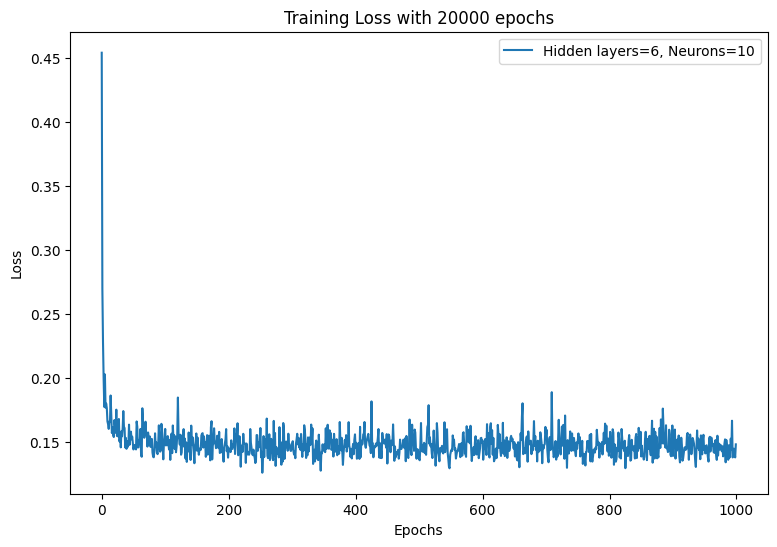

In [15]:
# %% Neural Network Surrogate
# %%
 #tensorflow and numpy for numerics

# matplotlib for plotting
matplotlib.rcParams['figure.figsize'] = [9, 6]

print("TensorFlow version:", tf.__version__)


f_arr = tf.reshape(f, [n_sim, max_glob_id])
u_arr = tf.reshape(u, [n_sim , max_glob_id])
inp_scaler = StandardScaler()
out_scaler = StandardScaler()
fx = inp_scaler.fit(f_arr)
ux = out_scaler.fit(u_arr)
f = inp_scaler.transform(f_arr)
u = out_scaler.transform(u_arr)

num_input = max_glob_id
num_output = max_glob_id
num_hidden = [6]
num_neurons = [10]

plt.figure()

losses = []
models = []
for hidden_units in num_hidden:
    for neurons in num_neurons:
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(shape=(num_input,)))
        for _ in range(hidden_units):
            model.add(tf.keras.layers.Dense(neurons, activation=tf.keras.activations.get('tanh')))
            model.add(tf.keras.layers.Dropout(0.2))  # Adding dropout
        model.add(tf.keras.layers.Dense(num_output))

        # loss function
        model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[MeanSquaredError()])

        # train the model
        history = model.fit(
            f, u,
            epochs= 1000,
            batch_size=32,
            verbose=0
        )

        losses.append(history.history['loss'])
        models.append(model)

        label = f'Hidden layers={hidden_units}, Neurons={neurons}'
        plt.plot(history.history['loss'], label=label)
        #plt.plot(history.history['loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss with 20000 epochs')
plt.legend()
plt.show()



In [16]:
# %%
#getting the accuracy of the model from mean squared loss
pred = model(f)
rescaled_pred = out_scaler.inverse_transform(pred)
mse = tf.reduce_mean(tf.square(tf.cast(u_arr, dtype=tf.float32) - rescaled_pred))
print(mse)

tf.Tensor(0.06429994, shape=(), dtype=float32)


In [17]:
# %%
# testing the model



num_sim = 1000
s = 20000
cov = [[s * s, 0], [0, s * s]]
eps = np.random.multivariate_normal((-200000, -200000), cov, num_sim) # vector with 2 values


applied_f = []
for j in range(num_sim):
  applied_f.append([0, 0, 0, 0, 0, eps[j, 0], 0, 0, 0, eps[j, 1], 0, 0, 0, 0])

# Perform simulation
start_time = time.time()
applied_f = inp_scaler.transform(applied_f)
applied_f = np.transpose(applied_f) #14 x 1000
u_pred = np.zeros((max_glob_id, num_sim))  #14 x 1000
u_anlyt = np.zeros((max_glob_id, num_sim))

for i in range(num_sim):
    u_pred[:, i] = model(tf.reshape(applied_f[:, i],[1, 14]))
    u_anlyt[:,i] = compute_soln(matK, applied_f[:, i])

u_pred = np.transpose(out_scaler.inverse_transform(np.transpose(u_pred)))
nn_time = time.time() - start_time
print(u_pred.shape)

(14, 1000)


In [18]:
# %%
covU_nueralnetwork = np.cov(u_pred)
nn = np.linalg.norm(covU - covU_nueralnetwork)


## 5. Comparison & Metrics

In [19]:
# %% Comparison & Metrics
# %%
# Create a DataFrame to display the computation times
data = {
    "Method": ["KL expansion", "Monte Carlo Simulation", "Analytical ", "Neural Network"],
    "difference with Cu_KL": [eigen,monte,analytical,nn],
    "Computation Time (seconds)": [eigen_time, montecarlo_time, analytical_time, nn_time]
}

df = pd.DataFrame(data)
print(df)


                   Method  difference with Cu_KL  Computation Time (seconds)
0            KL expansion           0.000000e+00                    0.001008
1  Monte Carlo Simulation           1.153959e-06                    0.221067
2             Analytical            9.033528e-07                    0.000418
3          Neural Network           8.747292e-07                    9.844399
